# Email cimkézés és statisztikai kimutatások

## Mailbox library használata

In [1]:
import mailbox

In [25]:
emails = mailbox.mbox('../sch.mbox')

## Egyéb importok

In [26]:
from email.utils import parsedate
import pandas as pd
import re
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from flufl.bounce import all_failures
import email
%matplotlib inline

## Attributumok létrehozása, pandas dataframe-mé alakítás

In [27]:
def getwords(longstring):
    r = re.compile(r'[{}]'.format(punctuation))
    new_strs = r.sub(' ',longstring)
    return(len(new_strs.split()))

## Dictionary létrehozása, null értékek elhagyása, dátum formátum létrehozása

In [28]:
def get_date(raw_date):
    return str(parsedate(raw_date)[0]) + '/' + str(parsedate(raw_date)[1]) + '/' + str(parsedate(raw_date)[2])

In [29]:
mails=[]
for mail in emails:
    if not isinstance(mail.get_payload(),list) and mail["date"] is not None:
        mails.append({'from':mail['from'],
                    'to':mail['to'],
                    'subject':mail['subject'],
                    'char_count':len(mail.get_payload()),
                    'word_count':getwords(str(mail.get_payload())), 
                    'date': get_date(mail['date'])})

In [30]:
df = pd.DataFrame(mails)

In [31]:
df['date'] = pd.to_datetime(df.date)

In [33]:
df.head()

,char_count,date,from,subject,to,word_count
0,645,2013-07-27,supernatural@sch.bme.hu,BME VIKGólyatábor=20megh=C3=ADvó,magyarb94@gmail.com,92
1,409,2013-08-01,golya@wadon.sch.bme.hu,=?ISO-8859-2?Q?Gólyatábor_jelentkezés,magyarb94@gmail.com,54
2,409,2013-08-04,golya@wadon.sch.bme.hu,=?ISO-8859-2?Q?Gólyatábor_jelentkezés,magyarb94@gmail.com,54
3,350,2013-08-22,AdminSCH <noreply@admin.sch.bme.hu>,AdminSCH_-_az_SCH_Accountod_elkész=C3=BClt,Magyar_Balázs_Attila <magyarb94@gmail.com>,48
4,900,2013-08-26,None,=?UTF-8?QC3=89rtes=C3=ADtés=20kollégiumi=20fel...,magyarb94@gmail.com,155


## Levelek száma

In [34]:
df.count()[0]

200

## Példa a létrejövő adatokról : karakter szám, dátum, feladó, tárgy, címzett, szavak száma

In [35]:
df = df.sort('date')

## Napi lebontásban az emailek száma

In [36]:
groupby_date = df[['date','subject']].groupby('date').count().rename(columns={'subject':'darabszám'})

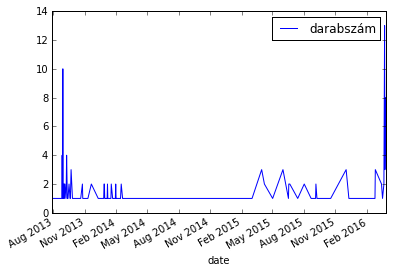

In [37]:
groupby_date.plot(kind='line')

## Emailek száma címzettenként

In [38]:
groupby_to = df[['to','subject']].groupby('to').count()

In [15]:
filtered_to = groupby_to[groupby_to['subject'] > 10]

In [16]:
filtered_to = filtered_to.rename(columns={'subject':'darabszám'})

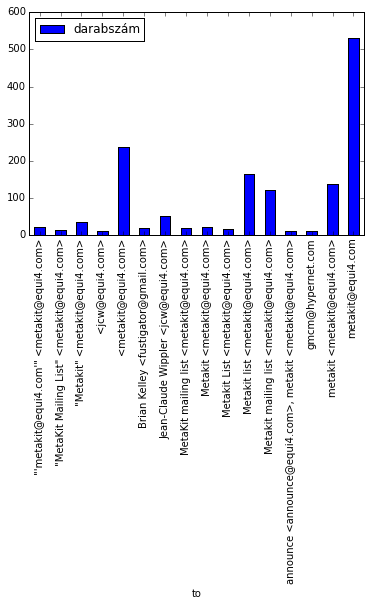

In [17]:
filtered_to.plot(kind='bar')

## Leghosszabb email

In [18]:
print df.loc[df['word_count'].idxmax()]

char_count                                                13380
date                                        2002-06-21 00:00:00
from                        targetemailextractor@btamail.net.cn
subject       [Metakit] ADV: Direct email blaster, email add...
to                                            metakit@equi4.com
word_count                                                 2536
Name: 688, dtype: object


# Címkézés (csak angol nyelvű emailekre)

## Üzenet szövegének listába rakása az klaszterező algoritmushoz

In [19]:
mail_payloads = []
for counter ,mail in enumerate(emails):
    if isinstance(mail.get_payload(), str):
        mail_payloads.append(mail.get_payload())
    else:
        for m in mail.get_payload():
            mail_payloads.append(m.get_payload())

## UTF-8 ra nem kódolható üzenetek kikukázása

In [20]:
utf8_mail_payloads = []
for mail in mail_payloads:
    try:
        utf8_mail_payloads.append(mail.decode(encoding='UTF-8',errors='strict'))
    except:
        utf8_mail_payloads.append("")

# Clustering  + létrjeövő címkék

In [21]:
# Címke csoportok számának megadása:
true_k = 5
# Címke csoportonkénti javaslatok számának megadása:
num = 3

In [22]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(utf8_mail_payloads)
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print "Cluster %d:" % i,
    for ind in order_centroids[i, :num]:
        print ' %s' % terms[ind],
    print

Top terms per cluster:
Cluster 0:  metakit  com  yahoo
Cluster 1:  vw  db  append
Cluster 2:  font  div  nbsp
Cluster 3:  metakit  python  file
Cluster 4:  view  row  data


# Visszapattanás detektálása

In [23]:
msg = all_emails.join(utf8_mail_payloads)

NameError: name 'all_emails' is not defined

In [24]:
msg = email.message_from_string(msg)

NameError: name 'msg' is not defined

In [41]:
temporary, permanent = all_failures(msg)

## Hard Bounced emails:

In [66]:
for bounce in permanent:
    print bounce

buf_=3D@0xbce7a968
peodfyehrsbg@spammotel.com


## Soft Bounced emails:

In [67]:
for bounce in temporary:
    print bounce